This notebook will continue the introduction to data analysis with a focus on classification algorithms. Classification is critical in a wide variety of physics research, especially when the problems are inherently multi-dimensional.
For this lab, we will contine our focus on real data obtained from molecular dynamics simulations of proteins.

Part 1: Data Exploration

Explore the data with a corner plot. This plot shows the histogram of each column on the diagonal and then contour plots of two columns at a time.

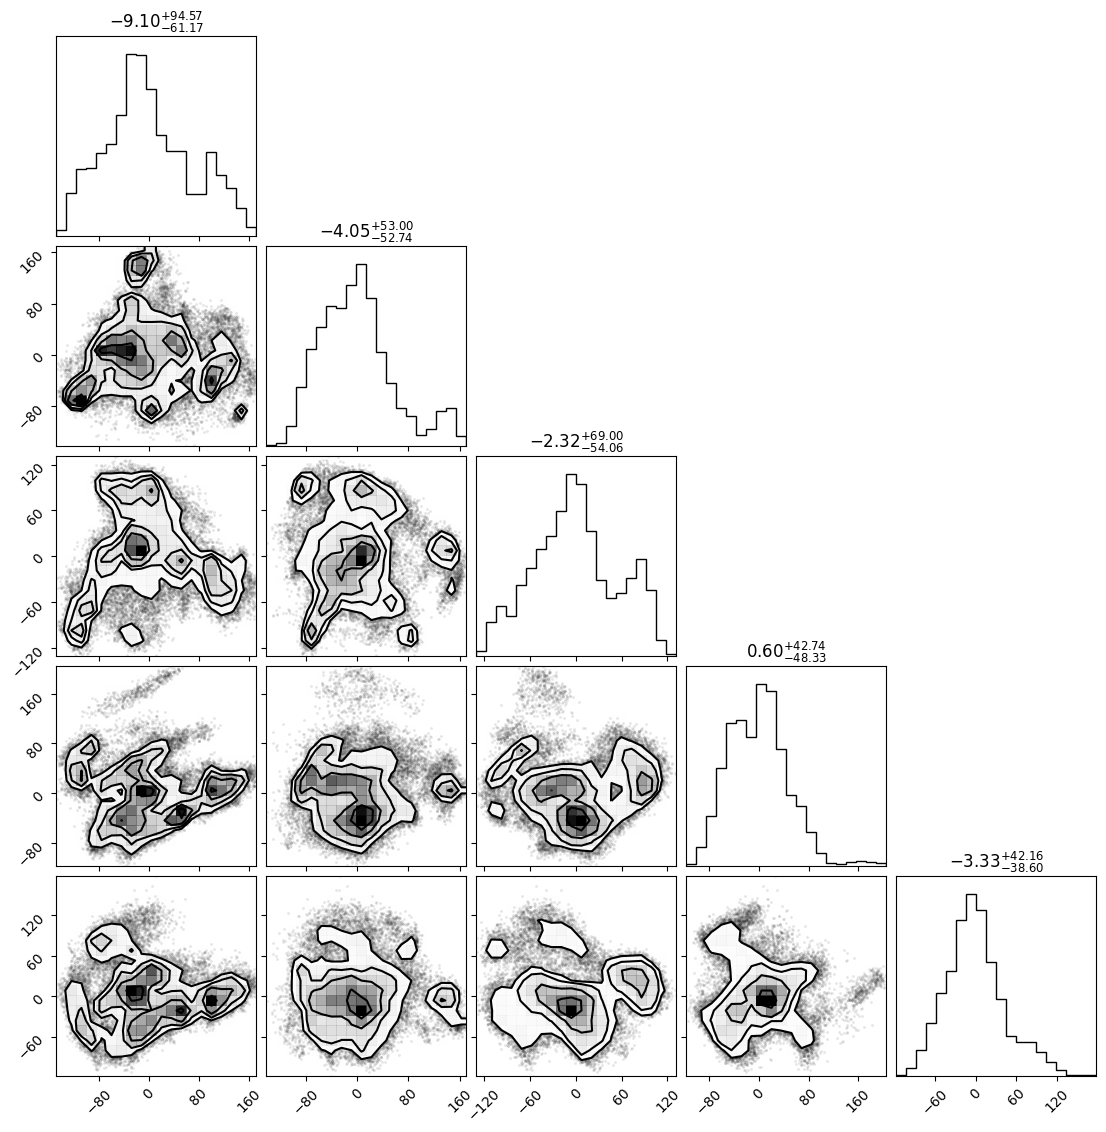

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import corner

column_names = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
data = pd.read_csv('../data/TM_projections.txt', sep='\s+', names=column_names, header=None)


fig = corner.corner(data, show_titles=True)
plt.show()


Questions 1:
Do these plots suggest that looking at more than just the first two columns (aka the first two principle components) might be useful in understanding this sysyem? Explain your answer. Also, according to the histograms what happens to the data as column number increases?

Exercise 1: Comment every line of the code to explain what each line is doing.

In [2]:
#Commented code

Hopefully it is clear that we need to incoporate information from more than just the first two princple compontents. One general method is clustering. This simple form of machine learning identifies groups in your data.

**Part 2: K-means clustering on 2D data**

The simplest such clustering method is k-means clustering. K-means clustering is an unsupervised learning algorithm used to categorize unlabeled data into distinct groups based on similarity. The "K" in K-means represents the number of clusters into which the data is to be grouped. The algorithm operates by identifying centroids (central points) for each cluster and assigning data points to the nearest cluster based on distance metrics, typically Euclidean distance.

Key Steps of K-means Clustering:

Initialization: Choose  k initial centroids randomly from the dataset, where  k is the desired number of clusters.

Assignment: Assign each data point to the nearest centroid, based on the distance between the data point and the centroid. This step groups the data into k clusters.

Update: Recalculate the centroids as the mean of all points assigned to each cluster.

Iteration: Repeat the assignment and update steps until the centroids no longer change significantly, indicating that the algorithm has converged.

Pros and Cons of K-means clustering:
Pro: K-means is known for its simplicity and efficiency

Cons: The clusters produced are spherical and evenly sized, which might not be the case in many real datasets. It can also be sensitive to the initial choice of centroids and might converge to local optima. Although in Dr. Salsbury's experience this is rare. The number of clusters,k, needs to be specified in advance, however, it is rare to know the "best" number of clusters.

Choosing k: Techniques like the elbow method or silhouette analysis are often used to select an appropriate k by evaluating the clustering outcome for different k values.


Let us focus our attention first on just the first 2 columns, as we can plot the data easily

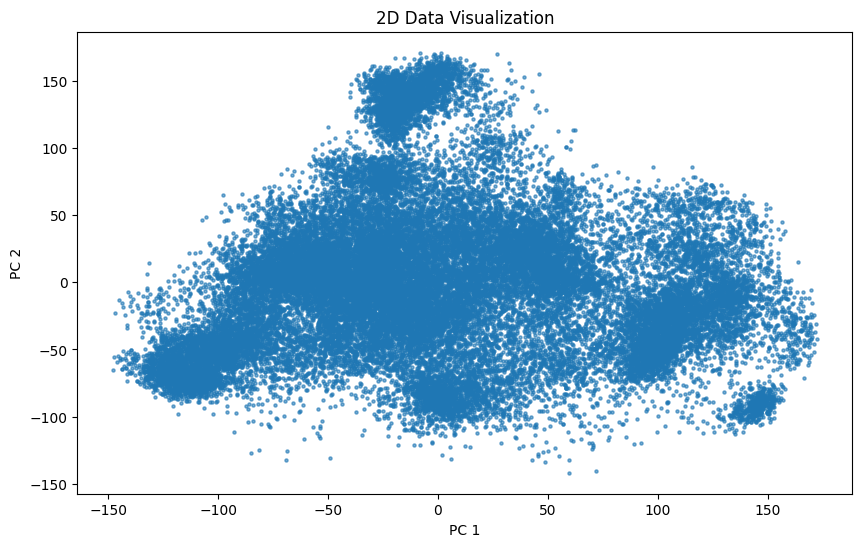

In [3]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.scatter(data[['PC1']], data[['PC2']], s=5, alpha=0.6)  # Plot the data points
plt.title('2D Data Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Question 2: How many clusters (aka groups of data points) do there think there should be? Explain why or why not. (At this point, it would be hard to have a wrong answer)

Let us start by doing two clusters on the first two colums.

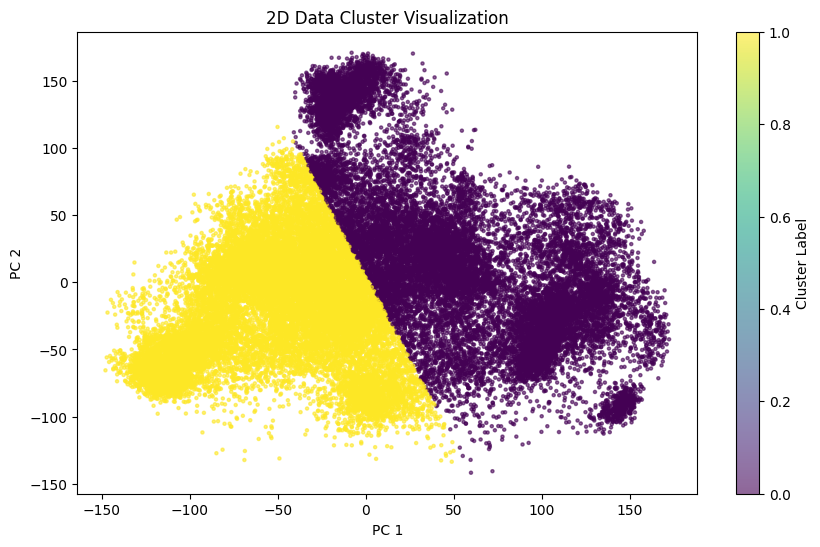

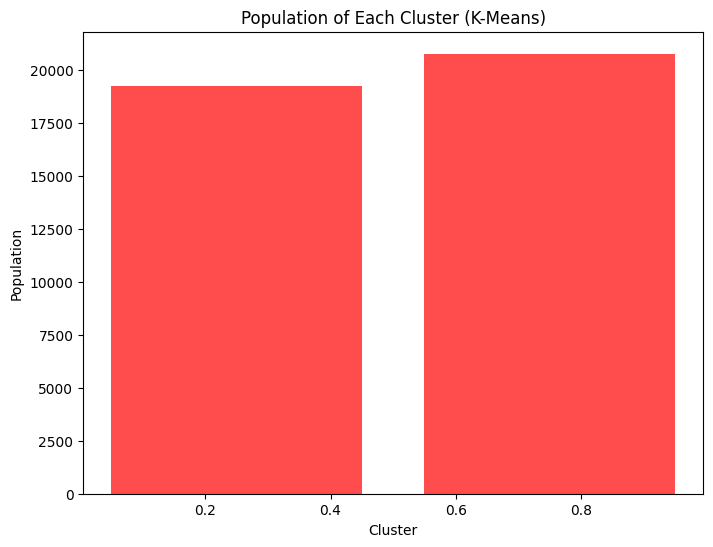

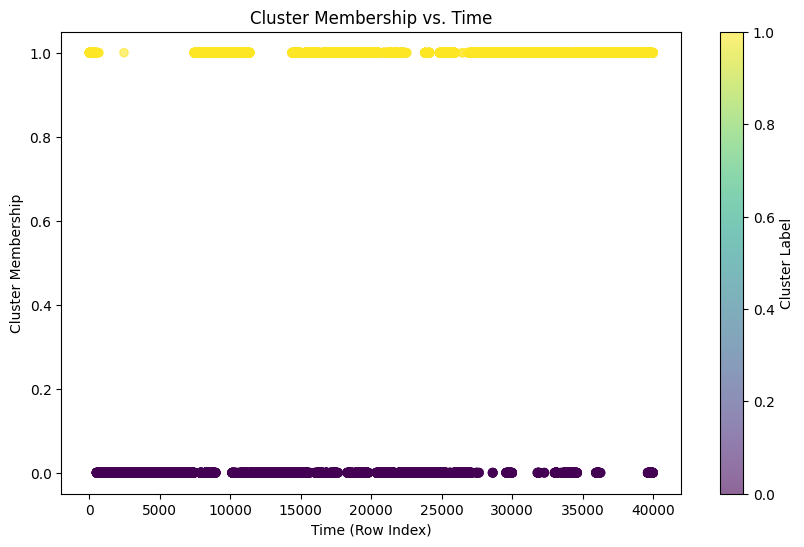

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42,n_init='auto')
kmeans.fit(data[['PC1', 'PC2']])
cluster_labels = kmeans.predict(data[['PC1', 'PC2']])

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.scatter(data[['PC1']], data[['PC2']],c=cluster_labels, cmap='viridis', s=5, alpha=0.6)  # Plot the data points
plt.title('2D Data Cluster Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster Label')  # Show color scale
plt.show()

# Plotting cluster populations
plt.figure(figsize=(8, 6))
plt.hist(cluster_labels, bins=2, rwidth=0.8, color='red', alpha=0.7)
plt.title('Population of Each Cluster (K-Means)')
plt.xlabel('Cluster')
plt.ylabel('Population')
plt.show()


# Generate a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data.index, cluster_labels, c=cluster_labels, cmap='viridis', alpha=0.6)

# Customize the plot
plt.title('Cluster Membership vs. Time')
plt.xlabel('Time (Row Index)')
plt.ylabel('Cluster Membership')
plt.colorbar(label='Cluster Label')

plt.show()




This divided the data into two nearly evenly divided groups. It should be clear this is a bad choice. 

Exercise 2: Cluster and visualize the data according to the number of clusters you hypothesized above. You will need to change more than one line of code.

In [10]:
#code for exercise 2


Compare your plots with at least two other people. Hopefully, it should be clear there needs to be a way to quantiatively decided on the number of clustering for it to be scientific.
Likely the most common mehtod is the silhouette score. 

**Silhouette Score**

The Silhouette Score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The Silhouette Score for a single sample is calculated as:

$$
s = \frac{b - a}{\max(a, b)}
$$

where:
- $a$ is the mean distance between a sample and all other points in the same class.
- $b$ is the mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Score for a set of samples is the average of all the individual samples' scores. Note, the silhouette score requires at least 2 clusters and at least 2 points per cluster. Silhouette scores are fairly computationally expensive, so sometimes other methods are used to narrow down the range of cluster numbers

One such method is the Within-Cluster sum of Squares.
 **Within-Cluster Sum of Squares (WCSS)**

The Within-Cluster Sum of Squares (WCSS) quantifies the variance within each cluster, aiming to capture the compactness of the clusters. A lower WCSS value indicates that the data points in each cluster are closer to their centroid, implying better cluster cohesion.  This is typically used with an "elbow" method where the number of clusters is varied and plotted and the number of clusters where the WCSS starts to level off is selected.

 WCSS is calculated by summing the squared distances between each point in a cluster and the centroid of that cluster, and then summing these values for all clusters.

$$
WCSS = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

where:
- $k$ is the number of clusters,
- $C_i$ is the set of points in cluster $i$,
- $x$ is a point in cluster $i$,
- $\mu_i$ is the centroid of cluster $i$.

This is much less compuationally costly, but doesn't include anything about how well-separated the clusters are. If one is pressed for time, what one typically does is plot this and look for the elbow and see where it "bends" and check Silhouette Scores in that area.

We are now going to calculate WSCC scores to get an idea as to what might be reasonable numbers of clusters. You migth also be able to get this by looking at the data if its 1D or 2D, bit maybe not.
Note, in Python the range command generates a half-open set so range(2,20) starts at 2 and ends at 19.

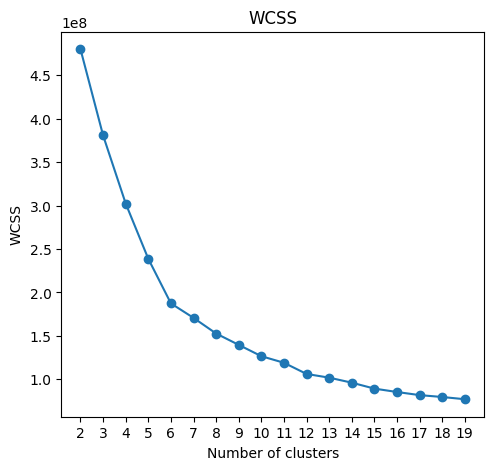

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

wcss = []
cluster_range = range(2, 20)  # Define cluster numbers explicitly

for i in cluster_range: 
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    
# Plot the elbow graph for WCSS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # subplot 1
plt.plot(list(cluster_range), wcss, marker='o', linestyle='-')
plt.title('WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(list(cluster_range));




We are now going to calculate the silhouette score for 2, 3 and 4 clusters. These are not optimal numbers of clusters, but this should give you an idea of how long it will take.

Let Dr. Salsbury know when you finish this as the next step requires the cooperation of the whole class.

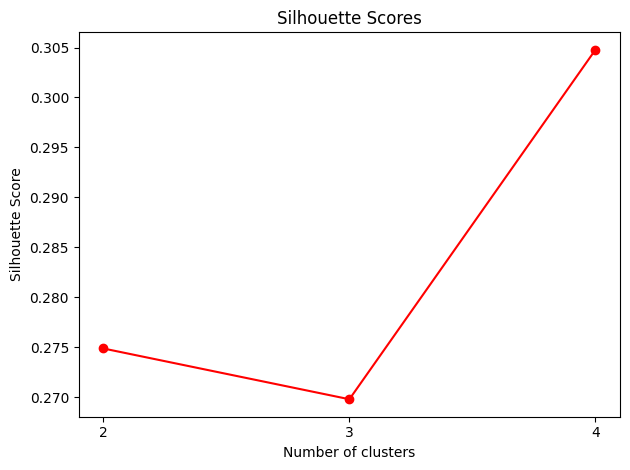

In [5]:
silhouette_scores = []
cluster_range = range(2, 5)  # Define cluster numbers explicitly

for i in cluster_range: 
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(data)

    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(data, labels))

# Plot the silhouette scores with correct x-axis values
plt.plot(list(cluster_range), silhouette_scores, marker='o', linestyle='-', color='red')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(list(cluster_range))  # Ensure the correct x-axis labels

plt.tight_layout()
plt.show()

Exercise 3: Based on the WCSS results, talk about which range of cluster numbers you want to examine, and divy it up among the class. Then perceed on

Exercise 4: Pick the optimal cluster number from the silhouette score and cluster and visualize the data using the k-means clustering method from above

In [41]:
#code for exercise 4


Part 3: K-means clustering with higher dimesional data

We worked through K-means with 2D data, but the actual data file has 5D data, and our first data exploration suggested that we should work with the full data set.
Exercise 5: It turns out for this data set, the optimal number of clusters (according to the Silhoutte score) is still 6. That is often not true, but we are lucky here. Cluster the 5D data into 6 clusters, calculate the Silhoutte score and visualize the clustering. For the 2D plot, use the first two principle components as your axes. 

In [43]:
#calculation and visualization code for exercise 5


Question 4: How does your 2D visualization compare to the previous ones? There should be a significant difference; identify it, explain it, and discuss why it is okay.

Part 4: HDBSCAN

K-means clustering is the most common clustering method used, and but has disadvantages. K-means clustering finds a set of spherical clusters that cover the data set, and requires a selection of cluster number (or size). HDBSCAN is an alternative method that clusters based on density and so neither requires spherical clusters or a cluster number. HDBSCAN does require setting of a minimum cluster size, which can be as low as 2, and also does not necessarily cluster all the data. Data that doesn't cluster well is considered as "noise".

/deac/opt/rocky9-noarch/deac-envs/classes/env-phy266/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/deac/opt/rocky9-noarch/deac-envs/classes/env-phy266/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


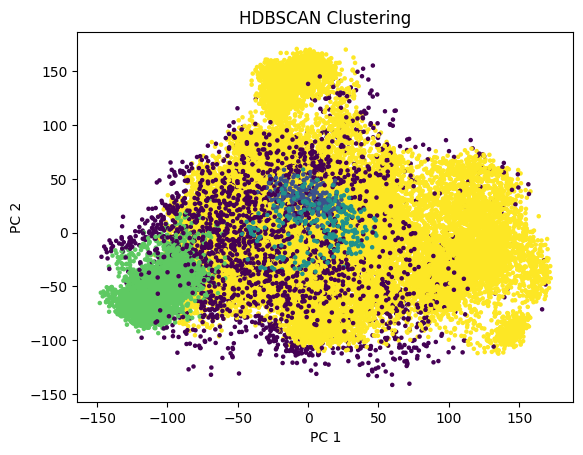

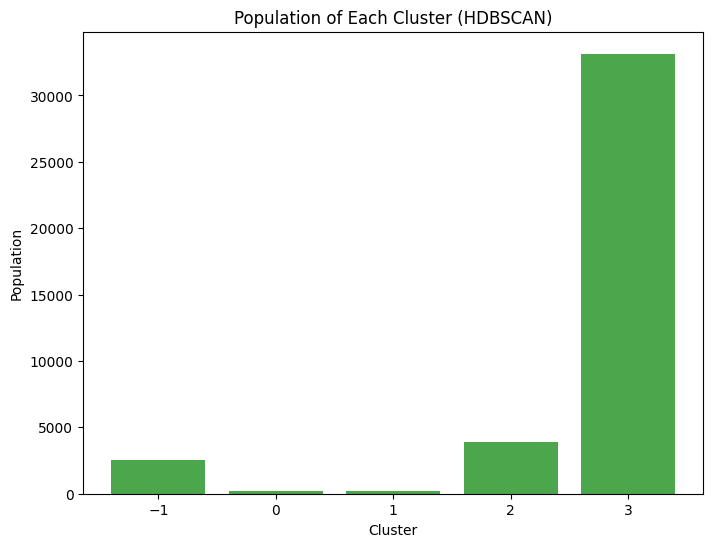

Silhouette Score: [np.float64(-0.23295387727997668)]


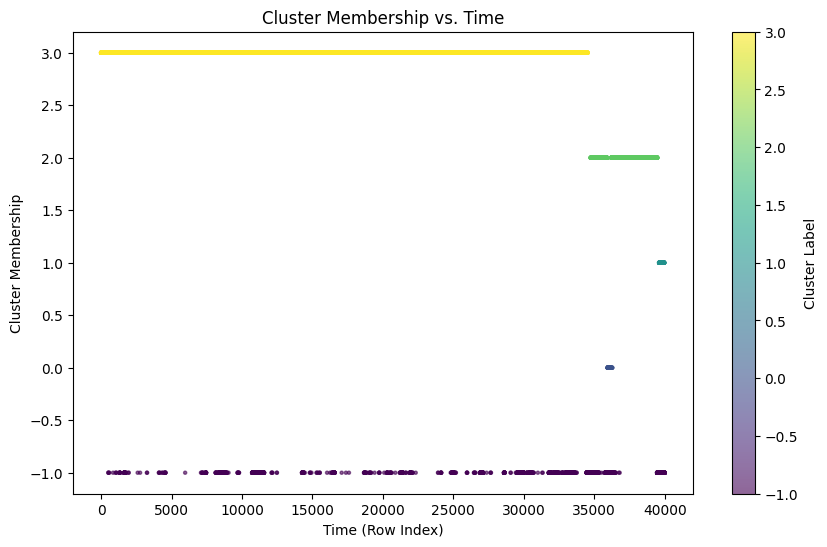

In [44]:
import hdbscan
import numpy as np 
from sklearn.metrics import silhouette_score

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(data)
# Plot the clusters
plt.scatter(data[['PC1']] , data[['PC2']], c=cluster_labels, cmap='viridis', s=5)
plt.title('HDBSCAN Clustering')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Finding unique clusters and their populations
unique, counts = np.unique(cluster_labels, return_counts=True)
clusters_population = dict(zip(unique, counts))


# Plotting cluster populations
plt.figure(figsize=(8, 6))
plt.bar(clusters_population.keys(), clusters_population.values(), color='green', alpha=0.7)
plt.title('Population of Each Cluster (HDBSCAN)')
plt.xlabel('Cluster')
plt.ylabel('Population')
plt.show()

# Generate a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data.index, cluster_labels, c=cluster_labels, cmap='viridis', alpha=0.6, s=5)

# Customize the plot
plt.title('Cluster Membership vs. Time')
plt.xlabel('Time (Row Index)')
plt.ylabel('Cluster Membership')
plt.colorbar(label='Cluster Label')

# Filter out noise points
filtered_data = data[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]


silhouette_scores = []
silhouette_scores.append(silhouette_score(filtered_data[['PC1', 'PC2']], filtered_labels))
print(f"Silhouette Score: {silhouette_scores}")

Question 5: Describe and discuss how the results of HDBSCAN clustering differed from the results of K-means clustering.

Exercise 5: Vary the min_cluster_size and see what happens. Include figures and discuss.

Exercise 6: Extend your work to the full 5D data.

In [45]:
#code for exercise 6
